In [1]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Project Summary: Baseball Team Data

#### Modelling Goal: 
The ultimate goal with this project is to model how people form into groups, and how these groups change over time. The secret purpose is to understand certain dangerous organizations, and predict how these groups will grow and change over time. But since the data on real dangerous organizations is classified and unavailable to me as a researcher, I will work with data for baseball players.

#### Data Needs:
For every player, the model will only include information on the player's team and position. Even though we have access to far more baseball data for every player, we will only use these features because that is the extent of the information availabe with the real version of this problem. Baseball data is readily available for download through the fangraphs.com website.

## Data Collection

The only challenge with collecting the data was sorting through all of the options available on the fangraphs website. There are several small caveats that make this surprisingly complex. First, I chose to use data that is post 1997 because there was a league expansion in that year that created several new teams.  

Another question I had to answer was what qualified someone as a member of a team. This is not as black and white as I had expected. There is a minimum number of plate appearances for a player to be considered a qualified hitter, which an average of 3.1 plate appearances per game, or about 500 per season. I chose 60 plate appearances as a low bar because I wanted to include more people, but still remove noise from players that only played a handful of games.

After making these decisions, it was a simple matter to select the information and download the player data. It was split into three csv files based on whether they were fielders, relief pitchers, or starter pitchers. Some players belonged to multiple categories, so I deal with that in the data cleaning.

## Data Cleaning

In [2]:
teams_abbr = {'- - -': '- - -', 'ANA': 'Angels', 'ARI': 'Diamondbacks', 
 'ATL': 'Braves', 'BAL': 'Orioles', 'BOS': 'Red Sox', 'CHC': 'Cubs', 
 'CHW': 'White Sox', 'CIN': 'Reds', 'CLE': 'Indians', 'COL': 'Rockies',
 'DET': 'Tigers', 'FLA': 'Marlins', 'HOU': 'Astros', 'KCR': 'Royals', 
 'LAA': 'Angels', 'LAD': 'Dodgers', 'MIA': 'Marlins', 'MIL': 'Brewers',
 'MIN': 'Twins', 'MON': 'Expos', 'NYM': 'Mets', 'NYY': 'Yankees',
 'OAK': 'Athletics', 'PHI': 'Phillies', 'PIT': 'Pirates', 'SDP': 'Padres',
 'SEA': 'Mariners', 'SFG': 'Giants', 'STL': 'Cardinals', 'TBD': 'Devil Rays', 
 'TBR': 'Rays', 'TEX': 'Rangers', 'TOR': 'Blue Jays', 'WSN': 'Nationals'}

Even though the data was easy to download, it came in three separate csv files, and one of them listed the teams by abbreviations. To solve this problem, I used to above dictionary to map the abbreviations to the proper team name.

#### Read Data and Change Team Abbreviation

In [3]:
#read in all data
sp = pd.read_csv('FanGraphs_Starters.csv')
rp = pd.read_csv('FanGraphs_Relievers.csv')
fd = pd.read_csv('FanGraphs_Fielders.csv')

a, b, c = len(sp),len(rp),len(fd)
print("""Number of starter pitchers:\t{}
Number of relief pitchers:\t{}
Number of fielders:\t\t{}
-------------------------------------
Total number of records:\t{}""".format(a, b, c, a+b+c))

#change abbreviation to full team name
fd.loc[[True]*len(fd),'Team'] = [teams_abbr[k] for k in fd.Team]

Number of starter pitchers:	3370
Number of relief pitchers:	1798
Number of fielders:		19193
-------------------------------------
Total number of records:	24361


In [4]:
#create a 3 sets containing tuples of playerids with the season for each record
fd_season_id = set([tuple(row) for row in fd[['playerid','Season']].values])
rp_season_id = set([tuple(row) for row in rp[['playerid','Season']].values])
sp_season_id = set([tuple(row) for row in sp[['playerid','Season']].values])

a, b, c = len(sp_season_id), len(rp_season_id), len(fd_season_id)
total = set()
total.update(sp_season_id);total.update(rp_season_id);total.update(fd_season_id)

print("Only counting players once per season.\n")
print("""Number of starter pitchers:\t{}
Number of relief pitchers:\t{}
Number of fielders:\t\t{}
-------------------------------------
Total number of records:\t{}""".format(a, b, c, len(total)))

Only counting players once per season.

Number of starter pitchers:	3370
Number of relief pitchers:	1798
Number of fielders:		14557
-------------------------------------
Total number of records:	15873


We have a problem; we wanted these numbers to match the numbers above. At the end of data cleaning, we want each player to have at most one record per season. In the above code, we find all combinations of playerid and season that exist in the datasets. A quick analysis reveals too major issues. The first is that, under the chosen criteria, we have duplicate records in the fielders dataframe. The second is that we have duplicates records between the different dataframes.

#### Remove Duplicates Part 1

In [5]:
#create temporary Seasonid column
fd.insert(2,'Seasonid',[tuple(row) for row in fd[['playerid','Season']].values])
rp.insert(2,'Seasonid',[tuple(row) for row in rp[['playerid','Season']].values])
sp.insert(2,'Seasonid',[tuple(row) for row in sp[['playerid','Season']].values])

#find and remove duplicates between dataframes
mask = fd.Seasonid.isin(sp_season_id)
fd.drop(fd[mask].index,inplace=True)

mask = fd.Seasonid.isin(rp_season_id)
fd.drop(fd[mask].index,inplace=True)

mask = rp.Seasonid.isin(sp_season_id)
rp.drop(rp[mask].index,inplace=True)

#remove temporary Seasonid column
fd.drop('Seasonid',axis=1,inplace=True)
sp.drop('Seasonid',axis=1,inplace=True)
rp.drop('Seasonid',axis=1,inplace=True)

Here, we resolve the issue for when players showed up in more than one of the files for a given season.

#### Reduce Number of Postions

In [6]:
#change all fielder positions (except catcher) to FD
fd.loc[fd.Pos.isin(['1B','2B','3B','RF','LF','CF','SS']),'Pos'] = 'FD'

#add column with potision to prepare for combining data
sp.insert(2, 'Pos', 'P')
rp.insert(2,'Pos', 'P')

At the recommendation of a knowledgable Baseball fan (Hayden Ringer), I chose to group the field positions together since they are essentially interchangeable, with the exception of the catcher. In fact, people often switch fielding positions throughout the season, which explains why my data has the same player listed multiple times a season, once per position. I address this at the end of cleaning.  

#### Combine Data

In [7]:
p = pd.concat([sp,rp,fd], ignore_index=True)
p.drop(p[p.Season<2002].index,inplace=True)
p.reset_index()
p.sample(5)

,Name,Pos,Season,Team,playerid
6274,Aaron Boone,FD,2002,Reds,311
7218,Craig Counsell,FD,2011,Brewers,52
7225,B.J. Surhoff,FD,2004,Orioles,117
14167,Nate Schierholtz,FD,2012,- - -,6201
18800,Bill Bray,P,2006,- - -,8538


We finally combine the three separate datasets into one. We also remove all data before 2002 because only one of the files contained the years before 2002.

#### Team Cleaning

In [8]:
#account for team name changes
p.loc[p.Team=='Devil Rays','Team'] = 'Rays'
p.loc[p.Team=='Expos','Team'] = 'Nationals'
del(teams_abbr['MON'])
del(teams_abbr['TBD'])

#delete players from a season if their team is unknown
p.drop(p[p.Team=='- - -'].index,inplace=True)
del(teams_abbr['- - -'])

These two teams, the Rays and the Nationals, changed cities partway through the time period 2002-2016, and their names also changed. To maintain continuity, I keep the orginal names instead.  

The "- - -" indicates that the player switched teams partway through a season. Since we don't know which specific team these players belonged to for this season, we remove them. This may be a source of error when we begin modeling, but it is realistic that we have incomplete information for the real problem, anyway.

#### Removing Duplicates Part 2

In [9]:
print("Number of records before:\t{}".format(len(p)))
p.drop_duplicates(inplace=True)
print("Number of records after:\t{}".format(len(p)))

Number of records before:	17490
Number of records after:	13560


These duplicates occurred because many of the fielders play multiple positions, and they had a record for every position they played in a given season.

## Feature Engineering
#### Add a new field called Change_Type

There isn't much that we can or should do for feature engineering on this set. The goal is to mainly use the graph properties and its changes over time to predict future changes. So we want to know, based on previous baseball teams how teams might form and change in the future. With that in mind, it is important to label individuals based on whether they just arrived at a team in a given season or are leaving the team at the end of the season. Sometimes, players will do both.

In [10]:
#initialize the new column with value 'No Change'
p.insert(1, 'Change_Type', 'No Change')

In [11]:
by_player = p.groupby('playerid')

#loop through, player by player
for g in by_player.groups:
    one_p = by_player.get_group(g)
    
    #loop through the years for each player
    for y in sorted(one_p['Season'])[1:]:
        
        #Case: no change
        if sum(one_p.Season==y-1)==0: continue
        
        #Case: arrive
        if (one_p[one_p.Season==y].Team.values[0] != 
        one_p[one_p.Season==y-1].Team.values[0]):
            
            #Case: arrive and previous arrive/leave
            if (p[(p.Season==y-1)&(p.playerid==g)]['Change_Type'].values[0]
            == 'Arrive'):
                p.loc[one_p[one_p.Season==y-1].index,'Change_Type'] = 'Arrive Leave'
                p.loc[one_p[one_p.Season==y].index,'Change_Type'] = 'Arrive'
            
            #Case: arrive and previous leave
            else:
                p.loc[one_p[one_p.Season==y-1].index,'Change_Type'] = 'Leave'
                p.loc[one_p[one_p.Season==y].index,'Change_Type'] = 'Arrive'

In [12]:
p.sample(5)

,Name,Change_Type,Pos,Season,Team,playerid
8956,Charlie Culberson,No Change,FD,2016,Dodgers,3298
20135,Mike Morin,No Change,P,2014,Angels,13442
553,Felipe Paulino,Arrive,P,2011,Royals,3777
7441,Alex Gordon,No Change,FD,2016,Royals,5209
19278,Eddie Bonine,No Change,P,2009,Tigers,5890


Since using a graph representation will be important to my project, I have included below the code for constructing some matrices that I will likely be using.

## Visualization

Visualizing this data is challenging. The only features in this baseball data are the positions, the change type, and the graph properties.

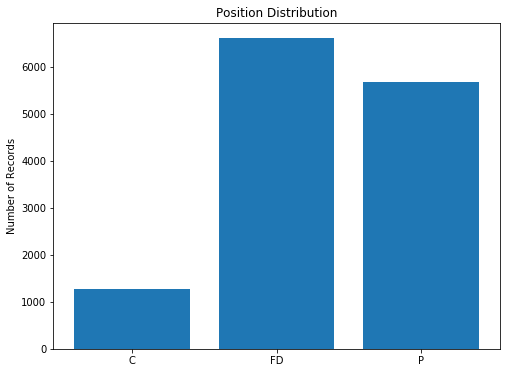

P - pitcher
FD - fielder
C - catcher


In [13]:
by_pos = p.groupby('Pos')
num_pos = len(p.Pos.unique())

plt.figure(figsize=(8,6))
plt.title("Position Distribution")
plt.bar(np.arange(num_pos), [len(df) for pos,df in by_pos.groups.items()])
plt.xticks(np.arange(num_pos), [pos for pos,df in by_pos.groups.items()])
plt.ylabel("Number of Records")
plt.show()
print("P - pitcher\nFD - fielder\nC - catcher")

This bar graph does not reveal anything unexpected. There are generally lots of fielders, and lots of pitchers (most of which are relief ptichers). And there are few catchers. Generally, a team will only have two or three catchers at a time.

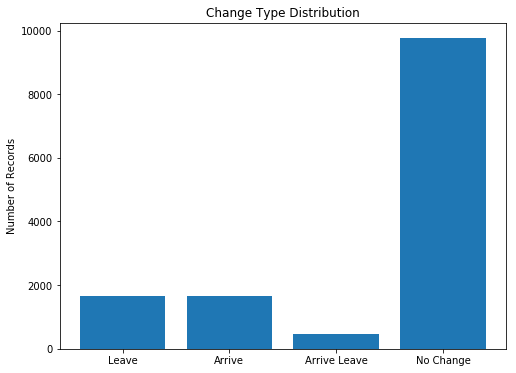

In [14]:
by_ct = p.groupby('Change_Type')
num_ct = len(p.Change_Type.unique())

plt.figure(figsize=(8,6))
plt.title("Change Type Distribution")
plt.bar(np.arange(num_ct), [len(df) for ct,df in by_ct.groups.items()])
plt.xticks(np.arange(num_ct), [ct for ct,df in by_ct.groups.items()])
plt.ylabel("Number of Records")
plt.show()

In [15]:
p08 = p[p.Season.isin(range(2008,1+2011))]

t_dct = {v:k for k,v in enumerate(p08.Team.unique())}
num_p = len(p08.playerid.unique())
num_t = len(p08.Team.unique())

A = np.zeros((num_t, num_p))

p08_dct = {v:k for k,v in enumerate(p08.playerid.unique())}

t = [0]*len(t_dct)
for team,num in t_dct.items():
    t[num] = team

for idx in p08.index:
    i = t_dct[p08.get_value(idx,'Team')]
    j = p08_dct[p08.get_value(idx,'playerid')]
    
    A[i,j] += 1

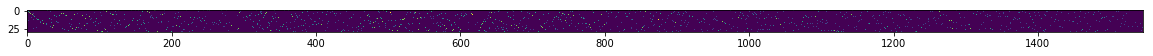

In [16]:
plt.figure(figsize=(20,5))
plt.imshow(A)
plt.show()

The above adjaceny matrix shows players belonging to each team in the four year time span. On its own, this is not very instructive.

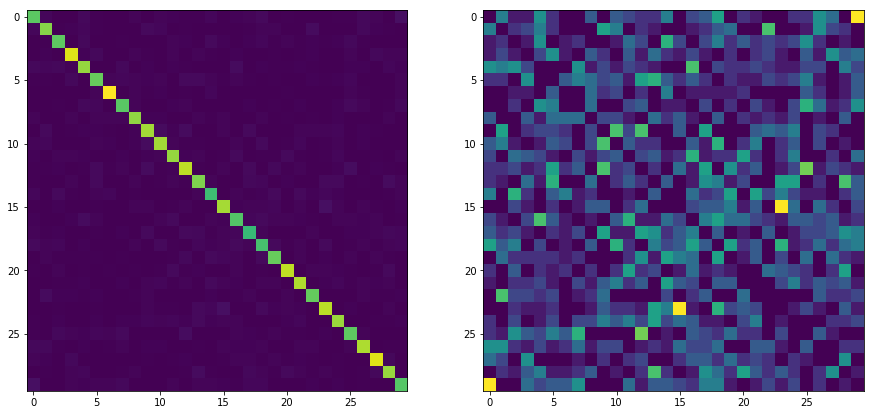

In [17]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(A.dot(A.T))
plt.subplot(122)
plt.imshow(A.dot(A.T)-np.diag(np.diag(A.dot(A.T))))
plt.show()

We can multiply the adjaceny matrix with its transpose to get a matrix that shows the number of connections from one team to another through players. The left matrix is overpowered by the diagonal, since each team is obviously highly connected to itself. When we remove the diagonal, the right matrix is the result. This is very interesting in that it is not perfectly uniform. There are two high points. The first one corresponds to the strong connection between Pirates and the Nationals. The other is between the Rangers and the Angels. I don't have an explanation for this, but it is exciting to see these unexpected connections.

In [18]:
g = nx.Graph()
for i,row in enumerate(A.T):
    js = np.arange(len(row))[row>0]
    for j in js:
        g.add_edge(i, t[j])

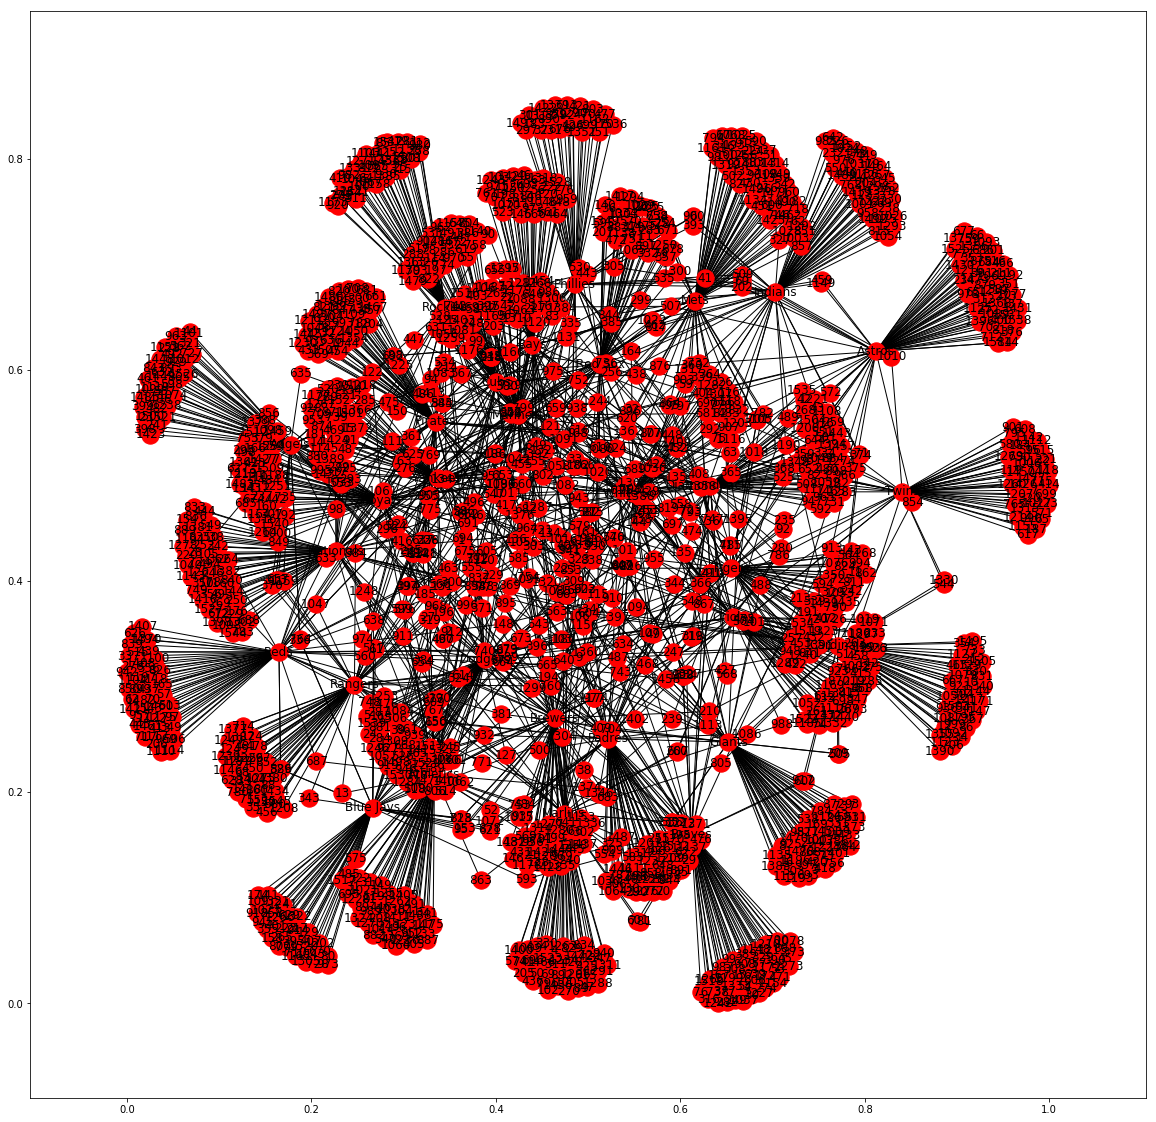

In [19]:
plt.figure(figsize=(20,20))
nx.draw_networkx(g)
plt.show()

Well, this just looks cool, but I should probably get rid of it. This graph shows the connections between players and teams in the time period 2008-2011.